In [37]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [38]:
dataset = pd.read_csv('./data/aim_business_cluster_60101020016000109719_train.csv', 
                      names=['collectTime','metrisValue'], index_col='collectTime', 
                      header=0, 
                      parse_dates=['collectTime'])
dataset.head()


,metrisValue
collectTime,
2020-03-14 16:01:00,467.0
2020-03-14 16:11:00,603.0
2020-03-14 16:21:00,615.0
2020-03-14 16:31:00,566.0
2020-03-14 16:41:00,515.0


In [39]:
# resample & fill the nan
single_index_series = dataset['metrisValue'].resample("10T").mean().ffill()

In [40]:
#split the train & test data set
training_set = single_index_series[:'2020/3/21'].values
test_set = single_index_series['2020/3/22':].values

In [41]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))

In [42]:
# Generate the train data, which contains the memory step data.
memory_step = 144
X_train = []
y_train = []
for i in range(memory_step,len(training_set_scaled)):
    X_train.append(training_set_scaled[i - memory_step:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [43]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1,)))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
912/912 [==============================] - 9s 10ms/step - loss: 0.0396
Epoch 2/30
912/912 [==============================] - 6s 6ms/step - loss: 0.0127
Epoch 3/30
912/912 [==============================] - 8s 9ms/step - loss: 0.0097
Epoch 4/30
912/912 [==============================] - 6s 7ms/step - loss: 0.0090
Epoch 5/30
912/912 [==============================] - 9s 10ms/step - loss: 0.0070
Epoch 6/30
912/912 [==============================] - 7s 8ms/step - loss: 0.0062
Epoch 7/30
912/912 [==============================] - 7s 8ms/step - loss: 0.0062
Epoch 8/30
912/912 [==============================] - 7s 8ms/step - loss: 0.0049
Epoch 9/30
912/912 [==============================] - 6s 7ms/step - loss: 0.0055
Epoch 10/30
912/912 [==============================] - 9s 10ms/step - loss: 0.0053
Epoch 11/30
912/912 [==============================] - 8s 9ms/step - loss: 0.0056
Epoch 12/30
912/912 [==============================] - 8s 9ms/step - loss: 0.0048
Epoch 13/30
912/912 [=

In [44]:
dataset_total = pd.concat((single_index_series[:'2020/3/21'], single_index_series['2020/3/22':]), axis=0)
inputs = dataset_total[len(single_index_series)-len(test_set) - memory_step:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
for i in range(memory_step, len(inputs)):
    X_test.append(inputs[i-memory_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_metrisValue = regressor.predict(X_test)
predicted_metrisValue = sc.inverse_transform(predicted_metrisValue)

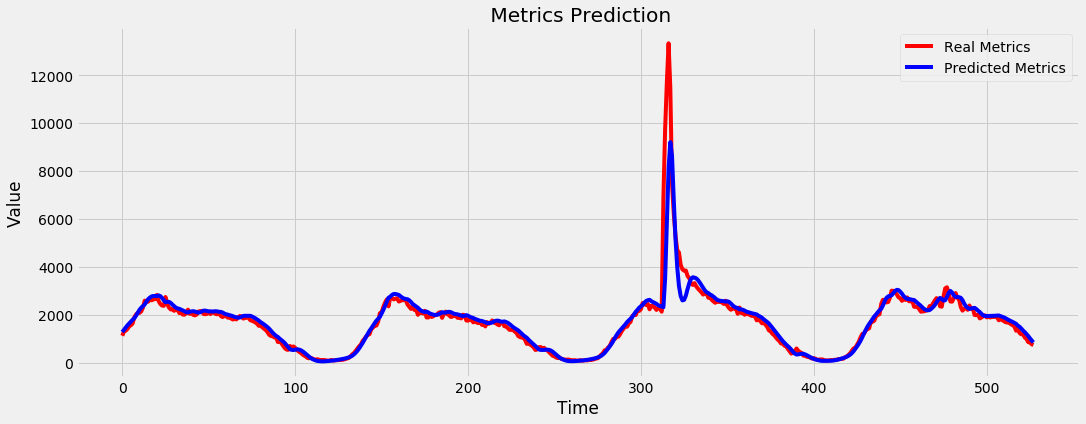

The root mean squared error is 527.8827335607132.


In [45]:
# LossFunction
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def plot_predictions(test,predicted):
    plt.figure(figsize=(16, 6))
    plt.plot(test, color='red',label='Real Metrics')
    plt.plot(predicted, color='blue',label='Predicted Metrics')
    plt.title(' Metrics Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
# return_rmse(test_set ,predicted_metrisValue)
plot_predictions(test_set, predicted_metrisValue)
return_rmse(test_set, predicted_metrisValue)